In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import pylab as pl
import astropy.units as u
import astropy.table as tb
from astropy.table import QTable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import mpl_toolkits.axisartist
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

##File of fancy plot style. To use des.mplstyle file you must have an LaTeX distribution in your system
plt.style.use(machine_path+'/Mestrado/cenarios/mandyoc/scripts_gera_inputs_imgs/new_outputs/des.mplstyle')

In [2]:
def read_params(fpath):
    '''
    Read param.txt and returns Nx, Nz, Lx, Lz of the scenario givem by fpath
    
    Parameters
    ----------
    
    fpath: str
        Path to the param.txt file
    '''
    
    with open(fpath+"param.txt","r") as f:
        line = f.readline()
        line = line.split() #split by space a string to a list of strings
        Nx = int(line[-1])
        
        line = f.readline()
        line = line.split()
        Nz = int(line[-1])

        line = f.readline()
        line = line.split()
        Lx = float(line[-1])

        line = f.readline()
        line = line.split()
        Lz = float(line[-1])

    return Nx, Nz, Lx, Lz


def read_data(prop, step, fpath):
    '''
    Read and reshape readed data according to parameters to return a (Nx, Nz) array.
    
    Parameters
    ----------
    
    prop: str
        Property of the mandyoc outputs: temperature, density, strain, strain_rate, viscosity, heat or pressure.
        
    step: str
        Time step of numerical scenario.
        
    fpath: str
        Path to the param.txt file.
    '''
    
    Nx, Nz, Lx, Lz = read_params(fpath)
    file_name = prop+"_"+str(step)+".txt"

    A = np.loadtxt(fpath+file_name, unpack=True, comments="P", skiprows=2)
    TT = A*1.0
    TT[np.abs(TT)<1.0E-200]=0
    TT = np.reshape(TT, (Nx,Nz), order='F')
    TTT = TT[:,:]

    return TTT
        
def read_density(fpath, step, Nx, Nz):
    '''
    Read and reshape readed data according to parameters to return a (Nx, Nz) array.
    
    Parameters
    ----------
    fpath: str
        Path to the param.txt file.
        
    step: str
        Time step of numerical scenario.
        
    Nx: int
        Number of points in x direction.
        
    Nz: int
        Number of points in z direction.
    '''

    Rho = np.loadtxt(fpath+"density_"+str(step)+".txt",skiprows=2, unpack=True, comments="P")
    Rho = np.reshape(Rho, (Nz, Nx))

    return Rho

def read_temperature(fpath, step, Nx, Nz):
    '''
    Read temperature data from temperature_step.txt  and reshape to a (Nz, Nx) array
    
    Parameters
    ----------
    fpath: str
        Path to the param.txt file.
        
    step: str
        Time step of numerical scenario.
        
    Nx: int
        Number of points in x direction.
        
    Nz: int
        Number of points in z direction.
    '''

    Temper = np.loadtxt(fpath+"temperature_"+str(step)+".txt",skiprows=2, unpack=True, comments="P")
    Temper = np.reshape(Temper, (Nz, Nx))

    return Temper

def extract_interface(z, Z, Nx, Rhoi, rho):
    '''
    Extract interface from Rhoi according to a given density (rho)

    Parameters
    ----------
    z: array_like
        Array representing z direction.

    Z: array_like
        Array representing z direction resampled with higher resolution.

    Nx: int
        Number of points in x direction.

    Rhoi: array_like (Nz, Nx)
        Density field from mandyoc

    rho: int
        Value of density to be searched in Rhoi field
    '''

    topo_aux = []

    for j in np.arange(Nx):
        topoi = interp1d(z, Rhoi[:,j]) #return a "function" of interpolation to apply in other array
        idx = (np.abs(topoi(Z)-rho)).argmin()
        topo = Z[idx]
        topo_aux = np.append(topo_aux, topo)

    return topo_aux

def find_nearest(array, value):
    '''Return the index in array nearest to a given value.
    
    Parameters
    ----------
    
    array: array_like
        1D array used to find the index
        
    value: float
        Value to be seached
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def read_times_steps(fpath):
    '''List and sort the time*.txt files
       
       Parameters
       ----------
       fapth: str
           Path to scenario directory.
    '''
    
    steps = []
    times = []
    
    ts = sorted(glob.glob(fpath+"time_*.txt"), key=os.path.getmtime)
    total_curves = len(ts)
    step_initial = int(ts[0].split('/')[-1][5:-4])
    step_final = int(ts[-1].split('/')[-1][5:-4])
    dstep = int(ts[1].split('/')[-1][5:-4]) - int(ts[0].split('/')[-1][5:-4])

    for step in range(step_initial, step_final+1, dstep):
        step = int(step)
        time_fname = "time_" + str(step) + ".txt"
        time = np.loadtxt(fpath+time_fname, usecols=2, max_rows=1)
        time = round(time/1.0E6, 2)
        steps = np.append(steps, int(step))
        times = np.append(times, time)
    steps = np.asarray(steps)
    steps = steps.astype('int')
    return times, steps

def trim_axs(axs, N):
    '''Little helper to index the axs as 1D list
       
       Parameters
       ----------
       axs: `~matplotlib.axes.Axes` list of Axes
           
       N: int
           Total number of subplots.
       
    '''
    
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def fit_func(x, a, b):
    '''
    Fit a linear function.
    
    Parameters
    ----------
    x: array_like
        Data points.
        
    a: float
        Angular coefficient.
        
    b: float
        Linear coefficient.
    '''
    
    return a*x + b

def plot_data(fpath, ax, axs, prop, step, xlims, ylims, letters):
    '''
    Plot data from mandyoc according to a given property.

    Parameters
    ----------
    fapth: str
           Path to scenario directory.
    
    ax: `~matplotlib.axes._subplots.AxesSubplot` Axis subplot.
    
    axs: 
        Numpy array of `~matplotlib.axes.Axes` list of Axes after use of trim_axis function.

    prop: str
        Property from mandyoc.     

    step: int
        Step of Mandyoc output files.
        
    xlims: list
        List with the limits of x axis
        
    ylims: list
        List with the limits of y axis
        
    letters: list
        List containing labels for subplots.
    '''
    
    #label of colorbars
#     print(prop)
    props_label = {'density': r'$\mathrm{kg/m^3}$',
                   'strain': 'Accumulated strain',
                   'lithology': 'Accumulated strain',
                   'strain_rate': r'log($\dot{\varepsilon}$)',
                   'viscosity': 'log(Pa.s)',
                   'temperature': r'$^{\circ}\mathrm{C}$',
                   'heat': 'log(W/kg)',
                   'pressure': 'GPa'
                   }
    
    props_cmap = {'density': 'viridis',
                   'strain': 'inferno',
                   'lithology': 'viridis',
                   'strain_rate': 'viridis',
                   'viscosity': 'viridis',
                   'temperature': 'viridis',
                   'heat': 'inferno',
                   'pressure': 'viridis'
                   }

    #limits of colorbars
    vals_minmax = {'density': [0.0, 3378.],
                 'strain': [None,None],
                 'lithology': [None,None],
                 'strain_rate':[np.log10(1.0E-19), np.log10(1.0E-14)],
                 'viscosity': [np.log10(1.0E16), np.log10(1.0E25)],
                 'temperature': [0,1600],
                 'heat': [np.log10(1.0E-13),np.log10(1.0E-9)],
                 'pressure': [-1.0E-3, 1.0]
                 }

    Nx, Nz, Lx, Lz = read_params(fpath)

    ##Creating a grid to plot
    xi = np.linspace(0, Lx/1000, Nx)
    zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
    xx, zz = np.meshgrid(xi, zi)

#             idx = np.where(tab['Steps']==stp[0])[0][0]

    #Removing the mean uplift between of left side
    #condx = (xi >= 100) & (xi <= 600)
    # z_mean = np.mean(topography[condx])
    z_mean = 40.0 #np.mean(topo[condx])

    val_minmax = vals_minmax[prop]
    
    if(prop == 'lithology'):
        data = read_data('strain', step, fpath)
    else:
        data = read_data(prop, step, fpath)
    data[data==0] = 1.0E-28 #avoid log(0)
    
    if(prop == 'lithology' or prop == "strain" or prop == "strain_rate" or prop == "viscosity" or prop == "heat"):
        data = np.log10(data)
    
    fname = fpath+'sp_surface_global_' + str(step) + '.txt'
    topo = np.loadtxt(fname, unpack=True, skiprows=2, comments='P')/1.0E3
    topo = topo + 40
    condx = (xi >= 100) & (xi <= 400)
    mean = np.mean(topo[condx])
    topoi = topo - np.abs(mean)
        
    #PLOT DATA
    
    if(prop != 'lithology' and prop != 'strain' and prop != 'pressure'): #properties that need a colorbar

        im = ax.imshow(np.transpose(data), cmap=props_cmap[prop], origin='lower',
                             extent=(0,Lx/1.0E3,-Lz/1.0E3+40,0+40), vmin=val_minmax[0], vmax=val_minmax[1], aspect='auto')

        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
#         ax.contour(xx, zz, Rhoi, 100, levels=interfaces, colors=['black', 'red'])

        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, colors=['red', 'red', 'red'])
        
        if(ax==axs[letters[1]]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'
            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
        if(ax == axs[letters[-1]]):
            axins1 = inset_axes(
                ax,
                width="30%",  # width: 30% of parent_bbox width
                height="5%",  # height: 5%
                bbox_to_anchor=(-0.02, -0.5, 1, 1),
                bbox_transform=ax.transAxes,
            )
            ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
            clb = fig.colorbar(im, cax=axins1, orientation='horizontal', fraction=0.08, pad=0.2, ticks=ticks,
                                        format='%.0f')
            clb.set_label(props_label[prop], fontsize=12)
            
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
        
#         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
        
    elif(prop == 'pressure'): #GPa 
        im = ax.imshow(np.transpose(data/1.0E9), cmap=props_cmap[prop], origin='lower',
                       extent=(0,Lx/1.0E3,-Lz/1.0E3+40,0+40), vmin=val_minmax[0], vmax=val_minmax[1], aspect='auto')
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
        
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
        
        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, colors=['red', 'red', 'red'])
        
        if(ax==axs[letters[1]]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
        axins1 = inset_axes(
                ax,
                width="30%",  # width: 50% of parent_bbox width
                height="5%",  # height: 5%
                bbox_to_anchor=(-0.02, -0.55, 1, 1),
                bbox_transform=ax.transAxes
            )
        
        ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
        clb = fig.colorbar(im, cax=axins1, orientation='horizontal', fraction=0.08, pad=0.2, ticks=ticks,
                                    format='%.3f')
        clb.set_label(props_label[prop], fontsize=12)
        clb.ax.tick_params(labelsize=10) 

        
    elif(prop == 'lithology'): #shaded lithology plot
        cr = 255.
        color_uc = (228./cr,156./cr,124./cr)
        color_lc = (240./cr,209./cr,188./cr)
        color_lit = (155./cr,194./cr,155./cr)
        color_ast = (207./cr,226./cr,205./cr)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        ax.contourf(xx, zz, Rhoi, levels=[200., 2750, 2900, 3365, 3900],
                     colors=[color_uc,color_lc,color_lit,color_ast])
        
        im=ax.imshow(np.transpose(data), cmap='Greys', origin='lower', extent=(0,Lx/1.0E3,-Lz/1.0E3+40,0+40),
                     zorder=50, alpha=0.2, vmin=-0.5, vmax=0.7, aspect='auto')


        if(ax == axs[letters[-1]]):
            if(letters[-1] == 'f'):
                b1 = [0.87, 0.14, 0.08, 0.08] #smaller plot
            elif(letters[-1] == 'g'):
                b1 = [0.87, 0.14, 0.08, 0.08]
                
            bv1 = plt.axes(b1)
            A = np.zeros((100, 10))

            A[:25, :] = 2700
            A[25:50, :] = 2800
            A[50:75, :] = 3300
            A[75:100, :] = 3400

            A = A[::-1, :]

            xA = np.linspace(-0.5, 0.9, 10)
            yA = np.linspace(0, 1.5, 100)

            xxA, yyA = np.meshgrid(xA, yA)
            air_threshold = 200
            plt.contourf(
                xxA,
                yyA,
                A,
                levels=[air_threshold, 2750, 2900, 3365, 3900],
                colors=[color_uc, color_lc, color_lit, color_ast],
            )

            plt.imshow(
                xxA[::-1, :],
                extent=[-0.5, 0.9, 0, 1.5],
                zorder=100,
                alpha=0.2,
                cmap=plt.get_cmap("Greys"),
                vmin=-0.5,
                vmax=0.9,
            )

            bv1.set_yticklabels([])
            plt.xlabel(r"log$(\varepsilon_{II})$", size=14)
            bv1.tick_params(axis='x', which='major', labelsize=12)
            bv1.set_xticks([-0.5, 0, 0.5])
            bv1.set_yticks([])
            bv1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        
        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, colors=['red', 'red', 'red'])
        
        if(ax==axs[letters[1]]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]

#         ax.fill_between(xaux, topoi[condaux], 37.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
        
    else:
        im = ax.imshow(np.transpose(data), cmap=props_cmap[prop], origin='lower',
                             extent=(0,Lx/1.0E3,-Lz/1.0E3+40,0+40), vmin=val_minmax[0], vmax=val_minmax[1], aspect='auto')
    
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
        
        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, colors=['red', 'red', 'red'])
        
        if(ax==axs[letters[1]]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
    
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
        

def plot_Korenaga(machine_path, ax):
    '''
    Reproduce Fig 5 from Korenaga (2013) and plot tectonic regime of mandyoc numerical experiments
    
    Parameters
    ----------
    
    machine_path: str
        OS path: Users/<username> for MacOS or /home/<username> for linux
    
    ax: `~matplotlib.axes._subplots.AxesSubplot` Axis subplot.
        One ax of subplot_mosaic. Default is axs['c'] from main code    
    '''
    
    fpath = machine_path + '/Doutorado/cenarios/mandyoc/scripts/Korenaga_Fig5/'
    
    fnames_data = ['Herzberg_2010_points.txt',
                   'Korenaga_2013_Tp_Ur0_034.txt',
                   'Korenaga_2013_Tp_Ur0_084.txt',
                  ]

    lines = ['.', '-', '--']

    labels = ['Herzberg et al. (2010)',
              'Korenaga (2013) with Ur(0) = 0.34',
              'Korenaga (2013) with Ur(0) = 0.84',
              ]

    colors = ['xkcd:dark green',
              'xkcd:cerulean blue',
              'xkcd:scarlet'
              ]

    #Numerical experiments data
    Tp_estimatives = [1292, #lit80km #oC
                      1350,
                      1397.,
                      1352, #lit150km
                      1421,
                      1460]

    tecto_markers = ['^', #H_lit 80 km
                     '^',
                     '^',
                     's', #H_lit 150 km
                     's',
                     's']

    tecto_colors = ['xkcd:purple', #plate tectonics
                    'xkcd:bright orange', #sluggish tectonics
                    'xkcd:bright orange',
                    'xkcd:purple',
                    'xkcd:purple',
                    'xkcd:purple']

    #Plot data from Korenaga (2013) Fig. 5
    for data_fname, line, color, label in zip(fnames_data, lines, colors, labels):
        fname = fpath + data_fname
        time, Tp = np.loadtxt(fname, unpack=True, comments='#')

        if(data_fname == 'Korenaga_2013_Tp_Ur0_034.txt'):
            time_new = np.linspace(0, time[-1], 1001)
            f = interp1d(time, Tp, kind='linear')
            Tp_interp = f(time_new)

            #Lets fit a linear function to the first 1Gyr from the data

            #selecting the region of interest
            cond = (time >= 0) & (time <= 1.0)
            time_cut = time[cond]
            Tp_cut = Tp[cond]

            params = curve_fit(fit_func, time_cut, Tp_cut)
            [a, b] = params[0]

            time_projection = np.arange(-3, 1, 0.01)
            Tp_fit = a * time_projection + b

    #         ax.plot(time_projection[time_projection<=0], Tp_fit[time_projection<=0], '-', color = 'xkcd:jungle green', linewidth=1, markersize=14, label = '')

        ax.plot(time, Tp, line, color=color, linewidth=1, markersize=14, label = label)

    ax.plot(time_projection[time_projection <= 0], Tp_fit[time_projection <= 0], '-', color = 'xkcd:jungle green', linewidth=1, markersize=14, label = 'Future projection')
    #Plot numerical scenarios data
    fontsize=16
    for Tp_estimative, marker, color in zip(Tp_estimatives, tecto_markers, tecto_colors):
        if(Tp_estimative < 1350.0):
            idx = find_nearest(Tp_fit, Tp_estimative)
            time_estimative = time_projection[idx]
        else:
            idx = find_nearest(Tp_interp, Tp_estimative)
            time_estimative = time_new[idx]

        ax.plot(time_estimative, Tp_estimative, marker=marker, color=color, markersize=12)
        text = str(int(Tp_estimative))+ r' $^{\circ}$C'

        if(Tp_estimative == 1350):
            ax.text(time_estimative,
                    Tp_estimative - 25,
                    text,
                    color = color,
                    fontsize = fontsize)
        else:
            ax.text(time_estimative,
                    Tp_estimative + 10,
                    text,
                    color = color,
                    fontsize = fontsize)

# Plot Fig.5 from Korenaga (2013)

According to Korenaga (2013), the thermal history of the Earth can be expressed as:


$$ C \frac{\mathrm{d} T_i}{\mathrm{d} t} = H(t) - Q(t) \mathrm{,}$$

where $H$ is the heating by radioactive elements in the mantle and $Q$ is the surface heat loss by mantle convection. $T_i \approx T_p$, where $Tp$ is the mantle potential temperature.

The relative contribution of the internal heating to the mantle heat flux is expressed by the convective Urey ratio:
$$U_r(t) \equiv \frac{H(t)}{Q(t)} \mathrm{.}$$

He tested two values for the present-day Urey ratio $U_r(0) for a constant heat flux $Q$: 0.34 (Low $H$) and 0.84 (high $H$)

The code below show those tests and the estimatives for $T_p$ from the experiments of LAB stability.

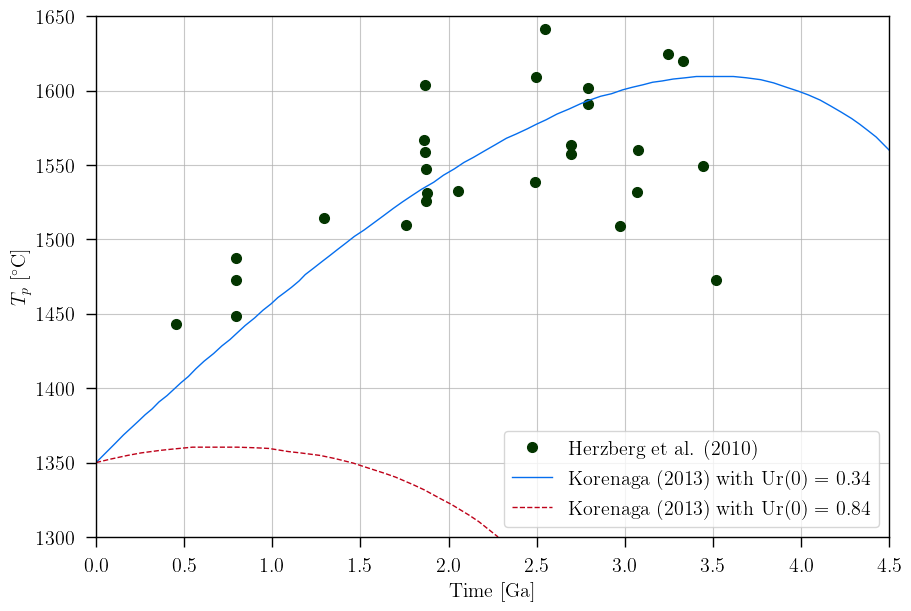

In [14]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(9,6), constrained_layout=True)

fpath = machine_path + '/Doutorado/cenarios/mandyoc/scripts/Korenaga_Fig5/'

fnames_data = ['Herzberg_2010_points.txt',
               'Korenaga_2013_Tp_Ur0_034.txt',
               'Korenaga_2013_Tp_Ur0_084.txt',
               ]

lines = ['.', '-', '--']

labels = ['Herzberg et al. (2010)',
          'Korenaga (2013) with Ur(0) = 0.34',
          'Korenaga (2013) with Ur(0) = 0.84',
          ]

colors = ['xkcd:dark green',
          'xkcd:cerulean blue',
          'xkcd:scarlet'
          ]
            
#Plot data from Korenaga (2013) Fig. 5
for data_fname, line, color, label in zip(fnames_data, lines, colors, labels):
    fname = fpath + data_fname
    time, Tp = np.loadtxt(fname, unpack=True, comments='#')

    ax.plot(time, Tp, line, color=color, linewidth=1, markersize=14, label = label)

#SET PLOT DETAILS
ax.grid('-k', alpha=0.7)
ax.set_xlim([0, 4.5])
ax.set_ylim([1300, 1650])
ax.set_xlabel('Time [Ga]')
ax.set_ylabel(r'$T_p$ [$^{\circ}$C]')

# ax.legend(loc='upper left', ncol=1)
ax.legend(loc='lower right', ncol=1)

figname = 'Korenaga_2013_Fig5'
fig.savefig('out/plots/' + figname + '.pdf', dpi=400)
fig.savefig('out/plots/' + figname + '.png', dpi=400)

# Plot Fig.5 from Korenaga (2013) and $T_p$ estimatives from numerical scenarios

According to Korenaga (2013), the thermal history of the Earth can be expressed as:


$$ C \frac{\mathrm{d} T_i}{\mathrm{d} t} = H(t) - Q(t) \mathrm{,}$$

where $H$ is the heating by radioactive elements in the mantle and $Q$ is the surface heat loss by mantle convection. $T_i \approx T_p$, where $Tp$ is the mantle potential temperature.

The relative contribution of the internal heating to the mantle heat flux is expressed by the convective Urey ratio:
$$U_r(t) \equiv \frac{H(t)}{Q(t)} \mathrm{.}$$

He tested two values for the present-day Urey ratio $U_r(0) for a constant heat flux $Q$: 0.34 (Low $H$) and 0.84 (high $H$)

The code below show those tests and the estimatives for $T_p$ from the experiments of LAB stability.

Tp est:  1292 Time estimative:  -0.560000000000052
Tp est:  1350 Time estimative:  0.0
Tp est:  1397 Time estimative:  0.423
Tp est:  1352 Time estimative:  0.018
Tp est:  1421 Time estimative:  0.6435
Tp est:  1460 Time estimative:  1.0214999999999999


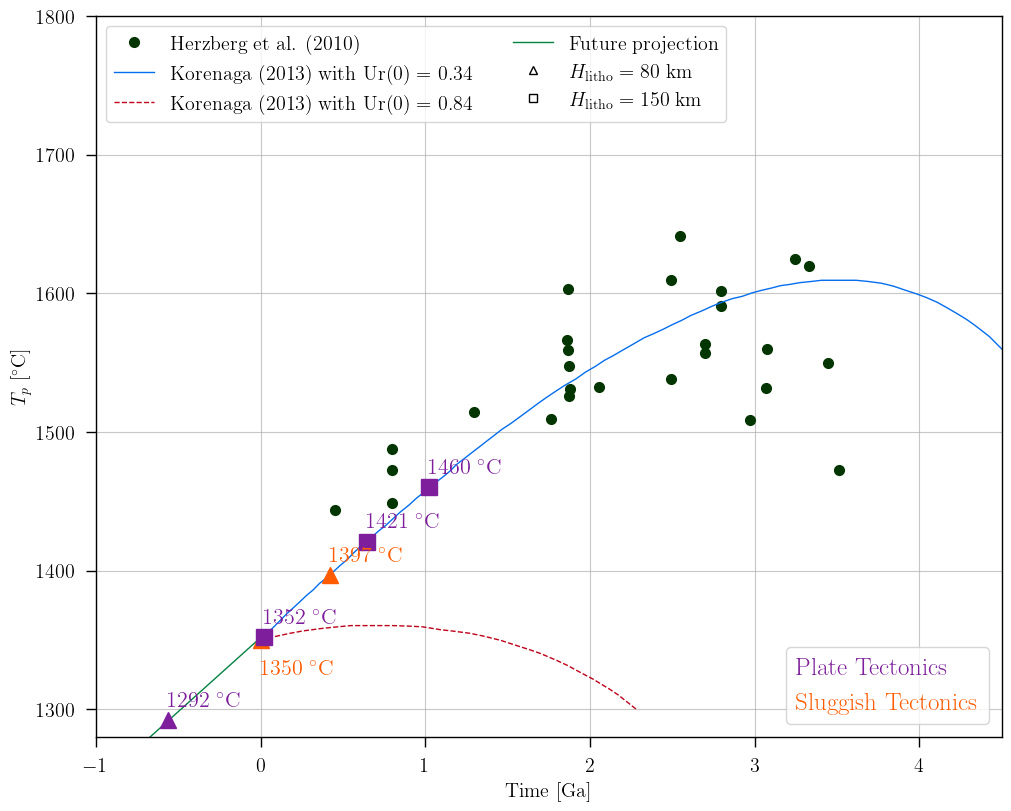

In [3]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(10,8), constrained_layout=True)

fpath = machine_path + '/Doutorado/cenarios/mandyoc/scripts/Korenaga_Fig5/'

# fname_034 = fpath + 'Korenaga_2013_Tp_Ur0_034.txt'
# fname_084 = fpath + 'Korenaga_2013_Tp_Ur0_084.txt'
# fname_herz = fpath + 'Herzberg_2010_points.txt'

# t034, korenaga_Ur034 = np.loadtxt(fname_034, unpack=True, comments='#')
# t084, korenaga_Ur084 = np.loadtxt(fname_084, unpack=True, comments='#')
# therz, herzberg = np.loadtxt(fname_herz, unpack=True, comments='#')

fnames_data = ['Herzberg_2010_points.txt',
               'Korenaga_2013_Tp_Ur0_034.txt',
               'Korenaga_2013_Tp_Ur0_084.txt',
               ]

lines = ['.', '-', '--']

labels = ['Herzberg et al. (2010)',
          'Korenaga (2013) with Ur(0) = 0.34',
          'Korenaga (2013) with Ur(0) = 0.84',
          ]

colors = ['xkcd:dark green',
          'xkcd:cerulean blue',
          'xkcd:scarlet'
          ]

#Numerical experiments data
Tp_estimatives = [1292, #lit80 km #oC
                  1350,
                  1397,
                  1352,#lit150km
                  1421,
                  1460]

tecto_markers = ['^', #H_lit 80 km
                 '^', 
                 '^',
                 's', #H_lit 150 km
                 's',
                 's']
            
tecto_colors = ['xkcd:purple', #plate tectonics
                'xkcd:bright orange', #sluggish tectonics
                'xkcd:bright orange',
                'xkcd:purple',
                'xkcd:purple',
                'xkcd:purple']
            
#Plot data from Korenaga (2013) Fig. 5
for data_fname, line, color, label in zip(fnames_data, lines, colors, labels):
    fname = fpath + data_fname
    time, Tp = np.loadtxt(fname, unpack=True, comments='#')

    if(data_fname == 'Korenaga_2013_Tp_Ur0_034.txt'):
        time_new = np.linspace(0, time[-1], 1001)
        f = interp1d(time, Tp, kind='linear')
        Tp_interp = f(time_new)
        
        #Lets fit a linear function to the first 1Gyr from the data
        
        #selecting the region of interest
        cond = (time >= 0) & (time <= 1.0)
        time_cut = time[cond]
        Tp_cut = Tp[cond]
        
        params = curve_fit(fit_func, time_cut, Tp_cut)
        [a, b] = params[0]
        
        time_projection = np.arange(-3, 1, 0.01)
        Tp_fit = a*time_projection + b
        
#         ax.plot(time_projection[time_projection<=0], Tp_fit[time_projection<=0], '-', color = 'xkcd:jungle green', linewidth=1, markersize=14, label = '')
    
    ax.plot(time, Tp, line, color=color, linewidth=1, markersize=14, label = label)
    
ax.plot(time_projection[time_projection<=0], Tp_fit[time_projection<=0], '-', color = 'xkcd:jungle green', linewidth=1, markersize=14, label = 'Future projection')
#Plot numerical scenarios data
fontsize=16
for Tp_estimative, marker, color in zip(Tp_estimatives, tecto_markers, tecto_colors):
    
    
    if(Tp_estimative < 1350.0):
        idx = find_nearest(Tp_fit, Tp_estimative)
        time_estimative = time_projection[idx]
    else:
        idx = find_nearest(Tp_interp, Tp_estimative)
        time_estimative = time_new[idx]
        
    print('Tp est: ', Tp_estimative, 'Time estimative: ', time_estimative)
    ax.plot(time_estimative, Tp_estimative, marker=marker, color=color, markersize=12)
    text = str(int(Tp_estimative))+ r' $^{\circ}$C'
    
    if(Tp_estimative == 1350):
        ax.text(time_estimative,
                Tp_estimative - 25,
                text,
                color = color,
                fontsize = fontsize)
    else:
        ax.text(time_estimative,
                Tp_estimative + 10,
                text,
                color = color,
                fontsize = fontsize)


#SET PLOT DETAILS
ax.grid('-k', alpha=0.7)
ax.set_xlim([-1, 4.5])
ax.set_ylim([1280, 1800])
ax.set_xlabel('Time [Ga]')
ax.set_ylabel(r'$T_p$ [$^{\circ}$C]')

ax.plot(-10, 10., '^', color='xkcd:white', mec='k', label=r'$H_{\mathrm{litho}} = 80$ km')
ax.plot(-10, 10., 's', color='xkcd:white', mec='k', label=r'$H_{\mathrm{litho}} = 150$ km')

ax.legend(loc='upper left', ncol=2)
#creating a second legend
ax1 = ax.twinx()
ax1.axis('off')
ax1.plot(-10, 10., color='xkcd:purple', label='Plate Tectonics')
ax1.plot(-10, 10., color='xkcd:bright orange', label='Sluggish Tectonics')

ax1.legend(loc='lower right', labelcolor='linecolor', handlelength=0, handletextpad=0, fontsize=18)


figname = 'Korenaga_and_Tp_estimatives'
fig.savefig('out/plots/' + figname + '.pdf', dpi=400)
fig.savefig('out/plots/' + figname + '.png', dpi=400)

# Final state from accordion experiments and Plot Fig.5 from Korenaga (2013) with $T_p$ estimatives from numerical scenarios

Clc: 1
instant: 90.0/120.0 Myr
instant: 90.0/119.91 Myr
instant: 90.0/105.5 Myr
instant: 90.0/119.81 Myr
instant: 90.0/112.11 Myr
Korenaga_and_final_step_Clc1_lithology


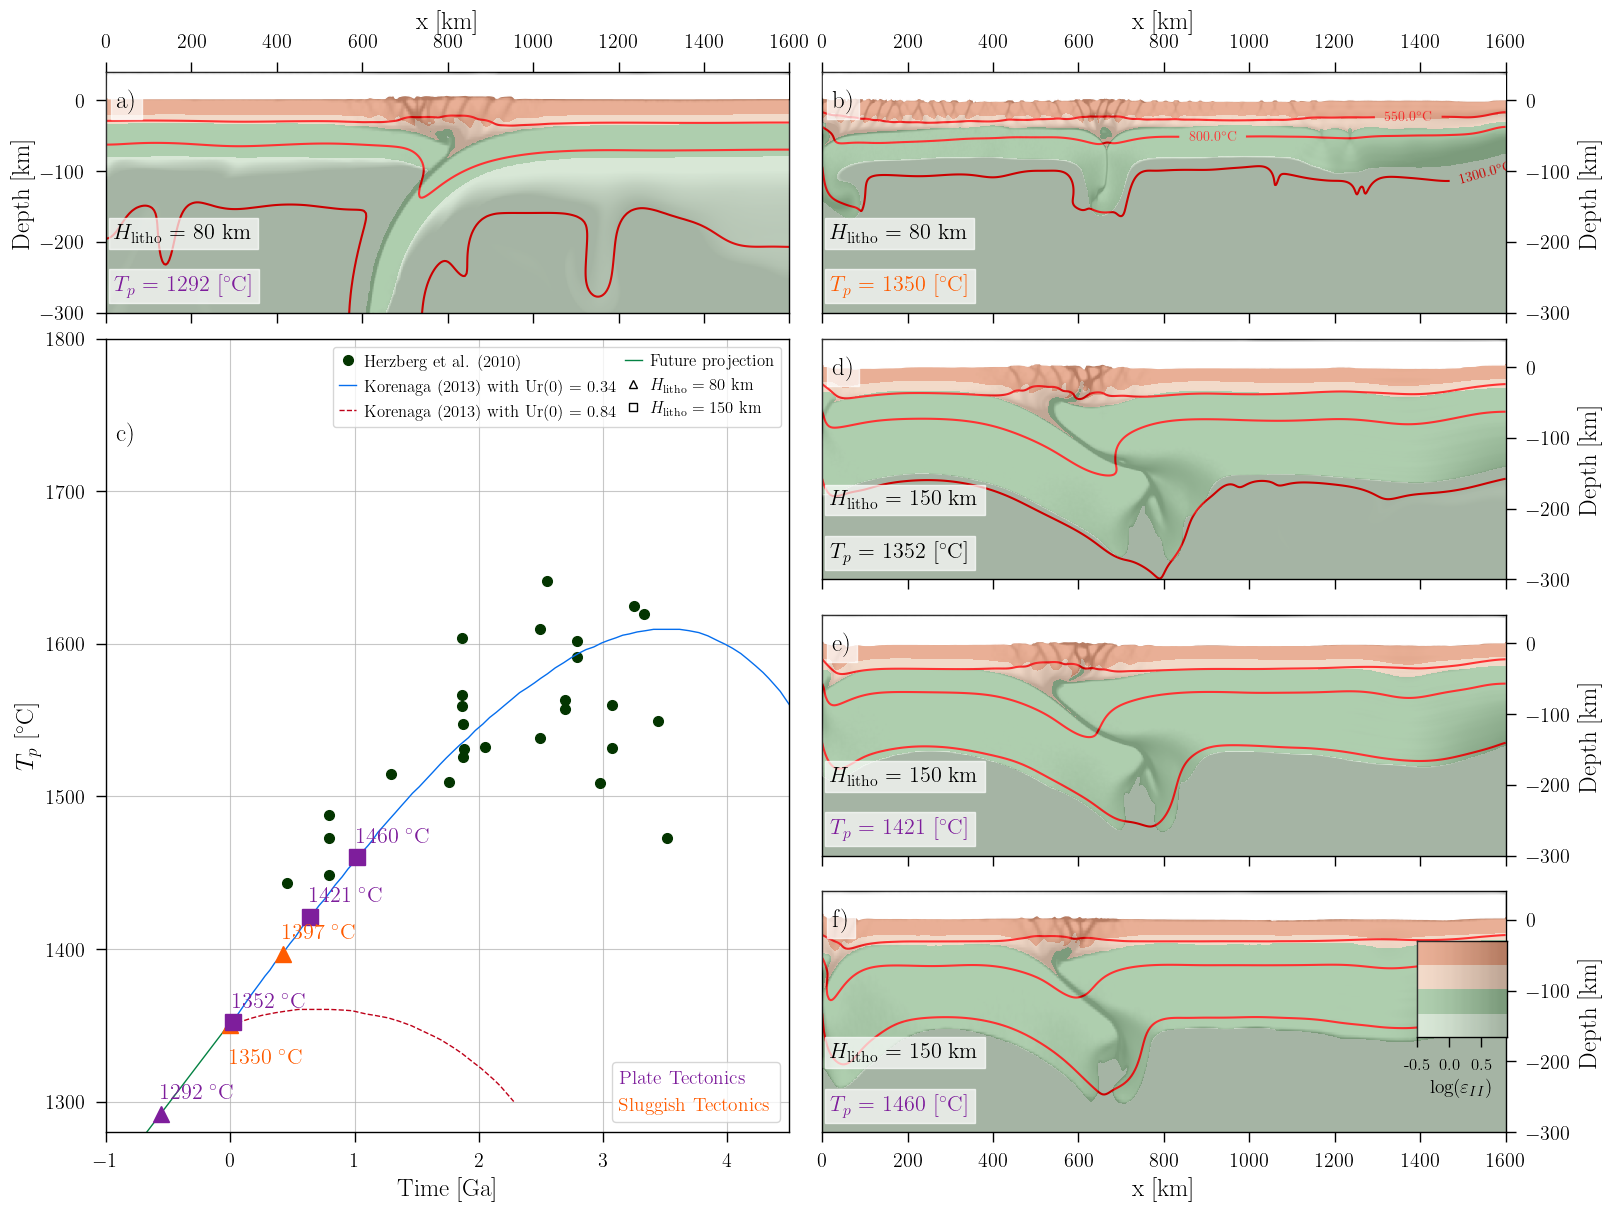

In [4]:
plt.close()

mosaic = '''
         aabb
         ccdd
         ccee
         ccff
         '''

fig, axs = plt.subplot_mosaic(mosaic,
                              constrained_layout=True,
                              figsize=(16,12),
                              gridspec_kw={'width_ratios':[1,1,1,1],
                                          'height_ratios':[1,1,1,1]}
                             )

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(axs)]

Clc=1
# Clc=10
print('Clc: '+str(Clc))

prop = 'lithology'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'pressure'

if(Clc == 1):
    scenarios = ['/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim001_rheol19_acc_DT200_PT1291oC_TBC_mean/', #a lit80km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT290_PT1349oC/Sim001_rheol19_acc_DT290_PT1349oC_TBC_mean/', #b lit80km
                 'trash',#c
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/Sim001_rheol19_acc_DT200_PT1352oC_TBC_mean_lit150km/', #d lit150km #uncomment later
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT290_PT1420oC/Sim001_rheol19_acc_DT290_PT1420oC_TBC_mean_lit150km/', #e lit150km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT350_PT1460oC/Sim001_rheol19_acc_DT350_PT1460oC_TBC_mean_lit150km/' #f lit150km
                ]
    
elif(Clc == 10):
    scenarios = ['/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim002_rheol19_acc_DT200_PT1291oC_TBC_mean/', #a lit80km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT290_PT1349oC/Sim002_rheol19_acc_DT290_PT1349oC_TBC_mean/', #b lit80km
                 'trash',#c
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/Sim002_rheol19_acc_DT200_PT1352oC_TBC_mean_lit150km/', #d lit150km #uncomment later
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT290_PT1420oC/Sim002_rheol19_acc_DT290_PT1420oC_TBC_mean_lit150km/', #e lit150km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT350_PT1460oC/Sim002_rheol19_acc_DT350_PT1460oC_TBC_mean_lit150km/' #f lit150km
                ]
    
xlims = [0, 1600]
ylims = [-300, 40]
for letter, scenario in zip(letters, scenarios):
    ax = axs[letter]
    
    if(letter == 'c'):
        plot_Korenaga(machine_path, ax)
    else:
#         if(letter == 'd'):
#             print('trash')
#             continue
            
        fpath = machine_path + scenario
        times, steps = read_times_steps(fpath)
        instant = 90.
#         instant = times[-1]
        print('instant: ' + str(instant) + '/' + str(times[-1]) + ' Myr')
        idx = find_nearest(times, instant)
        step = steps[idx]
        
        plot_data(fpath, ax, axs, prop, step, xlims, ylims, letters)


#set plot details
Tp_estimatives = [1292, #oC
                  1350,
                  '',
                  1352,
                  1421,
                  1460]

tecto_colors = ['xkcd:purple', #plate tectonics
                'xkcd:bright orange', #sluggish tectonics
                '',
                'xkcd:black',
                'xkcd:purple',
                'xkcd:purple']

H_lithos = [r'$H_{\mathrm{litho}} =$ 80 km',
            r'$H_{\mathrm{litho}} =$ 80 km',
            '',
            r'$H_{\mathrm{litho}} =$ 150 km',
            r'$H_{\mathrm{litho}} =$ 150 km',
            r'$H_{\mathrm{litho}} =$ 150 km']

fsize=18
for letter, Tp_estimative, color, H_litho in zip(letters, Tp_estimatives, tecto_colors, H_lithos):
    ax = axs[letter] #just for a better manipulation
    ax.text(0.015,
            0.88,
            letter + ')',
            color = 'k',
            fontsize = fsize,
            bbox = dict(edgecolor= 'white',
                        facecolor = 'white',
                        alpha = 0.7),
            horizontalalignment = 'left',
            verticalalignment = 'center',
            transform = ax.transAxes,
            zorder = 52)
    
    if(letter != 'c'):
        ax.text(0.012, 0.33, H_litho,
            color='k', fontsize=fsize-2,
            bbox=dict(edgecolor='white', facecolor='white', alpha=0.7),
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, zorder=52)
        
        text_tp = r' $T_p$ = ' + str(Tp_estimative) + ' [$^{\circ}$C]'
        ax.text(0.012,
                0.11,
                text_tp,
                color = color,
                fontsize = fsize-2,
                bbox = dict(edgecolor = 'white',
                            facecolor = 'white',
                            alpha = 0.7),
                horizontalalignment = 'left',
                verticalalignment = 'center',
                transform = ax.transAxes,
                zorder=52)
    
    if(letter == 'c'):
        ax.set_xlim([-1, 4.5])
        ax.set_ylim([1280, 1800])
        ax.grid('-k', alpha = 0.7)
        
        xlabel = 'Time [Ga]'
        ylabel = r'$T_p$ [$^{\circ}$C]'
        ax.set_xlabel(xlabel, fontsize=fsize)
        ax.set_ylabel(ylabel, fontsize=fsize)
        
        ax.plot(-10, 10., '^', color='xkcd:white', mec='k', label=r'$H_{\mathrm{litho}} = 80$ km')
        ax.plot(-10, 10., 's', color='xkcd:white', mec='k', label=r'$H_{\mathrm{litho}} = 150$ km')
#         ax.plot(-10, 10., '*', color='xkcd:white', mec='k', label=r'$H_{\mathrm{litho}} = 150$ km')

        ax.legend(loc = 'upper right',
                  ncol = 2,
                  handlelength = 1,
                  handletextpad = 0.5,
                  columnspacing = 0.5,
                  fontsize = 12)
        
        #creating a second legend
        ax1 = ax.twinx()
        ax1.axis('off')
        ax1.plot(-10, 10., color='xkcd:purple', label='Plate Tectonics')
        ax1.plot(-10, 10., color='xkcd:bright orange', label='Sluggish Tectonics')
#         ax1.plot(-10, 10., color='xkcd:black', label='No data yet')

        ax1.legend(loc = 'lower right',
                   labelcolor = 'linecolor',
                   handlelength = 0,
                   handletextpad = 0,
                   fontsize = 14)
        
    else:
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        xlabel = 'x [km]'
        ylabel = 'Depth [km]'
        
        if(letter == 'b' or letter == 'd' or letter == 'e' or letter == 'f'):
            #same ylabel
            ax.set_ylabel(ylabel, fontsize=fsize)
            
            ax.tick_params('y', left=False, right=True, labelleft=False, labelright=True)
            ax.yaxis.set_label_position("right")
            
            #handling with x axis: labels, ticks, tickpositions, etc...
            if(letter=='f'):
                ax.set_xlabel(xlabel, fontsize=fsize)

                ax.xaxis.set_tick_params(labelbottom=True)
                ax.tick_params('x', bottom=True, labelbottom=True)
                
            elif(letter == 'b'):
                ax.set_xlabel(xlabel, fontsize=fsize)
                
                ax.xaxis.set_label_position("top")
                
                ax.tick_params('x',
                               top=True, labeltop=True,
                               bottom=True, labelbottom=False)
                
            else: #d
                ax.tick_params('x',
                               bottom=True, labelbottom=False)
            
        else: #letter=='a'
            ax.set_xlabel(xlabel, fontsize=fsize)
            ax.set_ylabel(ylabel, fontsize=fsize)
            
            ax.xaxis.set_label_position("top")
            ax.yaxis.set_label_position("left")
            
            ax.tick_params('x',
                           top=True, labeltop=True,
                           bottom=True, labelbottom=False)
            
            ax.tick_params('y',
                           left=True, labelright=False,
                           right=False, labelleft=True)
            
figname = 'Korenaga_and_final_step_Clc' + str(Clc) + '_' + prop
print(figname)
fig.savefig('out/plots/' + figname + '.pdf', dpi=400)
fig.savefig('out/plots/' + figname + '.png', dpi=400)

Clc: 10
instant: 90.0/120.0 Myr
instant: 90.0/96.48 Myr
instant: 90.0/119.88 Myr
instant: 90.0/120.0 Myr
instant: 90.0/119.8 Myr
instant: 90.0/119.98 Myr
Korenaga_and_final_step_longer_Clc10_lithology


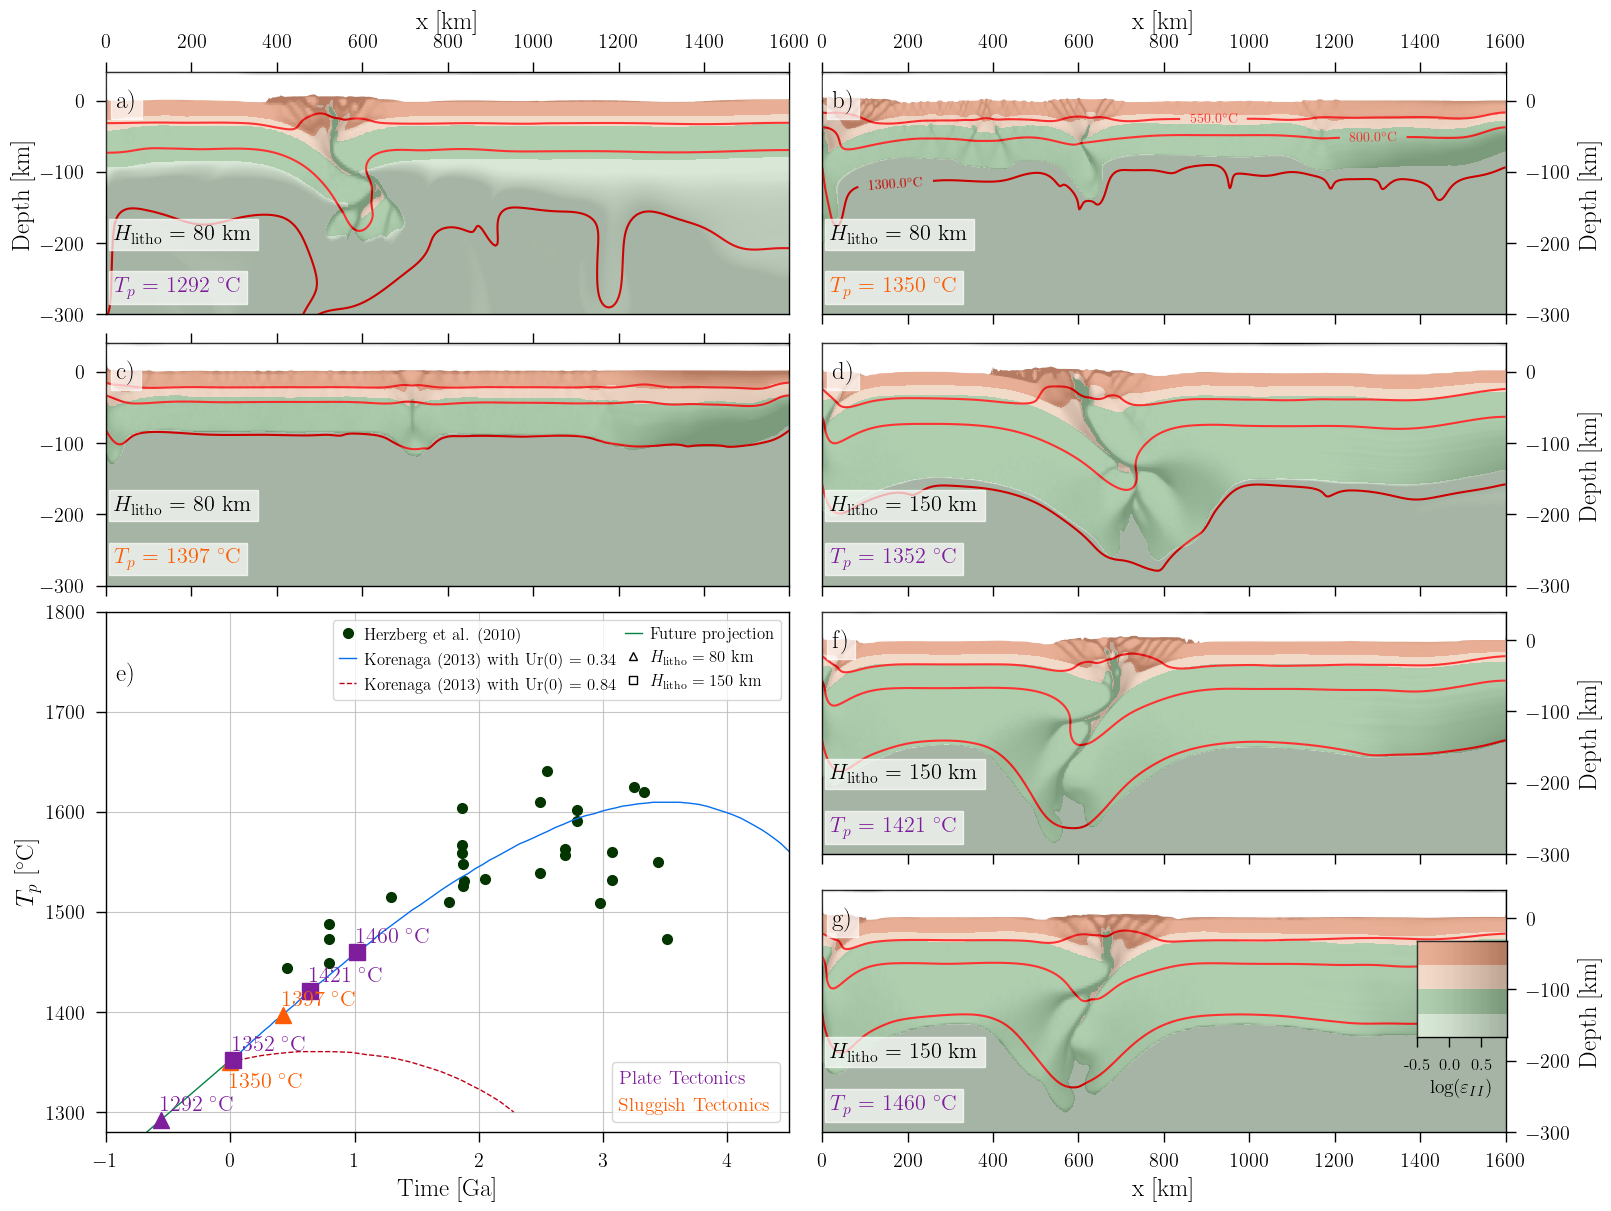

In [12]:
plt.close()


mosaic = '''
aabb
ccdd
eeff
eegg
'''

# mosaic = '''
# aabb
# ccdd
# ccee
# ccff
# '''

fig, axs = plt.subplot_mosaic(mosaic, constrained_layout=True,
                             figsize=(16,12),
                             gridspec_kw={'width_ratios':[1,1,1,1],
                                          'height_ratios':[1,1,1,1]}
                             )

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(axs)]

# Clc=1
Clc=10
print('Clc: '+str(Clc))

prop = 'lithology'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'pressure'

if(Clc == 1):
    scenarios = ['/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim001_rheol19_acc_DT200_PT1291oC_TBC_mean/', #a lit80km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT290_PT1349oC/Sim001_rheol19_acc_DT290_PT1349oC_TBC_mean/', #b lit80km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT400_PT1437oC/Sim001_rheol19_acc_DT400_PT1437oC_TBC_mean_lit80km/',#c lit80km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/Sim001_rheol19_acc_DT200_PT1352oC_TBC_mean_lit150km/', #d lit150km #uncomment later
                 'trash',#e
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT290_PT1420oC/Sim001_rheol19_acc_DT290_PT1420oC_TBC_mean_lit150km/', #f lit150km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT350_PT1460oC/Sim001_rheol19_acc_DT350_PT1460oC_TBC_mean_lit150km/' #g lit150km
                ]
    
elif(Clc == 10):
    scenarios = ['/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim002_rheol19_acc_DT200_PT1291oC_TBC_mean/', #a lit80km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT290_PT1349oC/Sim002_rheol19_acc_DT290_PT1349oC_TBC_mean/', #b lit80km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT400_PT1437oC/Sim002_rheol19_acc_DT400_PT1437oC_TBC_mean_lit80km/', #c lit80km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/Sim002_rheol19_acc_DT200_PT1352oC_TBC_mean_lit150km/', #d lit150km #uncomment later
                 'trash',#e
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT290_PT1420oC/Sim002_rheol19_acc_DT290_PT1420oC_TBC_mean_lit150km/', #e lit150km
                 '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT350_PT1460oC/Sim002_rheol19_acc_DT350_PT1460oC_TBC_mean_lit150km/' #f lit150km
                ]
    
xlims = [0, 1600]
ylims = [-300, 40]
for letter, scenario in zip(letters, scenarios):
    ax = axs[letter]
    
    if(letter=='e'):
        plot_Korenaga(machine_path, ax)
    else:
#         if(letter=='d'):
#             print('trash')
#             continue
            
        fpath = machine_path + scenario
        times, steps = read_times_steps(fpath)
        instant = 90.
#         instant = times[-1]
        print('instant: ' + str(instant) + '/' + str(times[-1]) + ' Myr')
        idx = find_nearest(times, instant)
        step = steps[idx]
        
        plot_data(fpath, ax, axs, prop, step, xlims, ylims, letters)


#set plot details
Tp_estimatives = [1292, #oC
                  1350,
                  1397,
                  1352,
                  '',
                  1421,
                  1460]

tecto_colors = ['xkcd:purple', #plate tectonics
                'xkcd:bright orange', #sluggish tectonics
                'xkcd:bright orange',
                'xkcd:purple',
                '',
                'xkcd:purple',
                'xkcd:purple']

H_lithos = [r'$H_{\mathrm{litho}} =$ 80 km',
            r'$H_{\mathrm{litho}} =$ 80 km',
            r'$H_{\mathrm{litho}} =$ 80 km',
            r'$H_{\mathrm{litho}} =$ 150 km',
            '',
            r'$H_{\mathrm{litho}} =$ 150 km',
            r'$H_{\mathrm{litho}} =$ 150 km']

fsize=18
for letter, Tp_estimative, color, H_litho in zip(letters, Tp_estimatives, tecto_colors, H_lithos):
    ax = axs[letter] #just for a better manipulation
    ax.text(0.015,
            0.88,
            letter + ')',
            color = 'k',
            fontsize = fsize,
            bbox = dict(edgecolor = 'white',
                      facecolor = 'white',
                      alpha = 0.7),
            horizontalalignment = 'left',
            verticalalignment = 'center',
            transform = ax.transAxes,
            zorder = 52)
    
    if(letter != 'e'):
        ax.text(0.012,
                0.33,
                H_litho,
                color = 'k',
                fontsize = fsize - 2,
                bbox = dict(edgecolor = 'white',
                            facecolor = 'white',
                            alpha = 0.7),
                horizontalalignment = 'left',
                verticalalignment = 'center',
                transform = ax.transAxes,
                zorder = 52)
        
        text_tp = r' $T_p$ = ' + str(Tp_estimative) + ' $^{\circ}$C'
        ax.text(0.012,
                0.11,
                text_tp,
                color = color,
                fontsize = fsize - 2,
                bbox = dict(edgecolor = 'white',
                            facecolor = 'white',
                            alpha = 0.7),
                horizontalalignment = 'left',
                verticalalignment = 'center',
                transform = ax.transAxes,
                zorder = 52)
    
    if(letter=='e'):
        ax.set_xlim([-1, 4.5])
        ax.set_ylim([1280, 1800])
        ax.grid('-k', alpha=0.7)
        
        xlabel = 'Time [Ga]'
        ylabel = r'$T_p$ [$^{\circ}$C]'
        ax.set_xlabel(xlabel, fontsize=fsize)
        ax.set_ylabel(ylabel, fontsize=fsize)
        
        ax.plot(-10, 10., '^', color='xkcd:white', mec='k', label=r'$H_{\mathrm{litho}} = 80$ km')
        ax.plot(-10, 10., 's', color='xkcd:white', mec='k', label=r'$H_{\mathrm{litho}} = 150$ km')
#         ax.plot(-10, 10., '*', color='xkcd:white', mec='k', label=r'$H_{\mathrm{litho}} = 150$ km')

        ax.legend(loc='upper right', ncol=2, handlelength=1, handletextpad=0.5, columnspacing=0.5, fontsize=12)
        #creating a second legend
        ax1 = ax.twinx()
        ax1.axis('off')
        ax1.plot(-10, 10., color='xkcd:purple', label='Plate Tectonics')
        ax1.plot(-10, 10., color='xkcd:bright orange', label='Sluggish Tectonics')
#         ax1.plot(-10, 10., color='xkcd:black', label='No data yet')

        ax1.legend(loc='lower right', labelcolor='linecolor', handlelength=0, handletextpad=0, fontsize=14)
        
    else:
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        xlabel = 'x [km]'
        ylabel = 'Depth [km]'
        
        if(letter == 'b' or letter == 'd' or letter == 'g' or letter == 'f'):
            #same ylabel
            ax.set_ylabel(ylabel, fontsize=fsize)
            
            ax.tick_params('y', left=False, right=True, labelleft=False, labelright=True)
            ax.yaxis.set_label_position("right")
            
            #handling with x axis: labels, ticks, tickpositions, etc...
            if(letter=='g'):
                ax.set_xlabel(xlabel, fontsize=fsize)

                ax.xaxis.set_tick_params(labelbottom=True)
                ax.tick_params('x', bottom=True, labelbottom=True)
                
            elif(letter == 'b'):
                ax.set_xlabel(xlabel, fontsize=fsize)
                
                ax.xaxis.set_label_position("top")
                
                ax.tick_params('x',
                               top=True, labeltop=True,
                               bottom=True, labelbottom=False)
                
            else:
                ax.tick_params('x',
                               bottom=True, labelbottom=False)
            
        elif(letter=='a'):
            ax.set_xlabel(xlabel, fontsize=fsize)
            ax.set_ylabel(ylabel, fontsize=fsize)
            
            ax.xaxis.set_label_position("top")
            ax.yaxis.set_label_position("left")
            
            ax.tick_params('x',
                           top=True, labeltop=True,
                           bottom=False, labelbottom=False)

            ax.tick_params('y',
                           left=True, labelleft=True,
                           right=False, labelright=False,)
                
                
        elif(letter == 'c'):
            ax.tick_params('x',
                           top=True, labeltop=False,
                           bottom=True, labelbottom=False)

            ax.tick_params('y',
                           left=True, labelleft=True,
                           right=False, labelright=False)
figname = 'Korenaga_and_final_step_longer_Clc' + str(Clc) + '_' + prop
print(figname)
fig.savefig('out/plots/' + figname + '.pdf', dpi=400)
fig.savefig('out/plots/' + figname + '.png', dpi=400)